In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from scipy import stats

plt.style.use('fivethirtyeight')

%matplotlib inline
pd.set_option('max_columns', 999)
pd.set_option('max_rows', 999)

In [2]:
#Very importand to know the shape of this so when we are done its the same counts!
train = pd.read_csv('../data/ames_train.csv')
train.shape

(2051, 81)

In [3]:
#Very important to know the shape of this so when we are done its exactly the same!
test_houses = pd.read_csv('../data/ames_test.csv')
test_houses.shape

(878, 80)

In [4]:
#Merge our training and testing datasets so we can manipulate them both at the same time.
all_data = pd.concat([train, test_houses])

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [5]:
#Dummify all the data at once...
df = pd.get_dummies(all_data, drop_first=True)

In [6]:
#Make Sure our Testing Dataset data all made it in and is the only null values in Sale Price.
df['SalePrice'].isnull().sum()

878

In [7]:
#Set Testing Dataset SalePrice to 0 so we can filter it back out later.
df.loc[df['SalePrice'].isnull(),['SalePrice']] = 0

In [8]:
#Start our normal Data Cleaning steps.

In [9]:
#Starting with checking for null values.
df.isnull().sum()

1st Flr SF                0
2nd Flr SF                0
3Ssn Porch                0
Bedroom AbvGr             0
Bsmt Full Bath            2
Bsmt Half Bath            2
Bsmt Unf SF               1
BsmtFin SF 1              1
BsmtFin SF 2              1
Enclosed Porch            0
Fireplaces                0
Full Bath                 0
Garage Area               1
Garage Cars               1
Garage Yr Blt           159
Gr Liv Area               0
Half Bath                 0
Id                        0
Kitchen AbvGr             0
Lot Area                  0
Lot Frontage            490
Low Qual Fin SF           0
MS SubClass               0
Mas Vnr Area             23
Misc Val                  0
Mo Sold                   0
Open Porch SF             0
Overall Cond              0
Overall Qual              0
PID                       0
Pool Area                 0
SalePrice                 0
Screen Porch              0
TotRms AbvGrd             0
Total Bsmt SF             1
Wood Deck SF        

In [10]:
#Null Values is Basement bathrooms.  Likely due to them not existing.  We will plug that with 0s.
df.loc[df['Bsmt Full Bath'].isnull(),['Bsmt Full Bath']] = 0
df.loc[df['Bsmt Half Bath'].isnull(),['Bsmt Half Bath']] = 0

#Null Values in Bsmn Unfinished and finished SQ FT. Again, likely due to it not existing.  Plug with 0.
df.loc[df['Bsmt Unf SF'].isnull(),['Bsmt Unf SF']] = 0
df.loc[df['BsmtFin SF 1'].isnull(),['Bsmt Unf SF']] = 0
df.loc[df['BsmtFin SF 2'].isnull(),['BsmtFin SF 2']] = 0
df.loc[df['Total Bsmt SF'].isnull(),['Total Bsmt SF']] = 0

#Null values in Garage Area and Garage Cars.  Probably because there is not a garage on the house.  Plug with 0.
df.loc[df['Garage Area'].isnull(),['Garage Area']] = 0
df.loc[df['Garage Cars'].isnull(),['Garage Cars']] = 0

#Null Values in Garage Yr Blt... so 159 times they dont have a garage... fill with 0.
df.loc[df['Garage Yr Blt'].isnull(),['Garage Yr Blt']] = 0

#490 Nulls in Lot Frontage.  Probably due to lots not having frontage.
df.loc[df['Lot Frontage'].isnull(),['Lot Frontage']] = 0

#Mas Vnr Area "Masonry veneer area in square feet" so probably not really any reason to not fill with 0.
df.loc[df['Mas Vnr Area'].isnull(),['Mas Vnr Area']] = 0

In [11]:
#Recheck for Nulls
df.isnull().sum().sum()

1

In [12]:
#Looks good.

In [13]:
#Now lets split out our data again.
sp_mask = df['SalePrice'] == 0
training_homes = df[~sp_mask]
testing_homes = df[sp_mask]

In [14]:
#And lets verify they are the same
print(f'The original shape of the Training Data was {train.shape}')
print(f'The resulting shape of the Training Data is {training_homes.shape}')
print(f'The original shape of the Testing Data was {test_houses.shape}')
print(f'The resulting shape of the Testing Data is {testing_homes.shape}')

The original shape of the Training Data was (2051, 81)
The resulting shape of the Training Data is (2051, 259)
The original shape of the Testing Data was (878, 80)
The resulting shape of the Testing Data is (878, 259)


*NEXT STEP IS EDA AND LOOKING AT VARIABLES*

In [15]:
#Lets start with the output, Sale Price.
training_homes['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

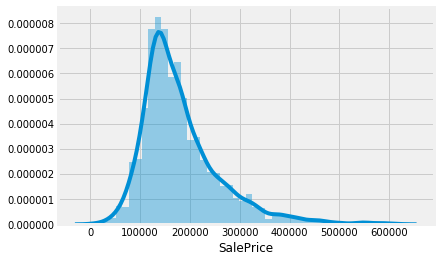

In [16]:
#Look at the distribution of our target variable.
sns.distplot(training_homes['SalePrice']);

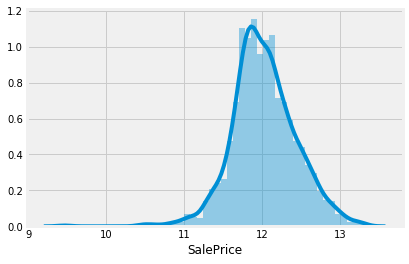

In [17]:
#Looks skewed-right with that long tail.  Maybe we can clean it up with some maths.
sns.distplot(np.log(training_homes['SalePrice']));

In [18]:
#looks better. But we have a skew left with that long tail. Lets see why:
training_homes['SalePrice'].sort_values(ascending=True)

1628     12789.0
183      13100.0
1309     34900.0
1292     35000.0
1518     35311.0
          ...   
151     556581.0
1796    582933.0
1692    584500.0
1964    591587.0
1671    611657.0
Name: SalePrice, Length: 2051, dtype: float64

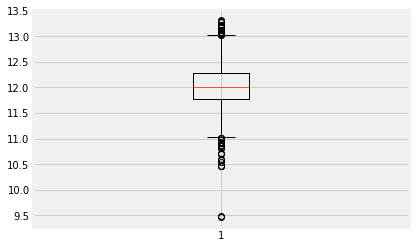

In [19]:
#Check to see if they are outliers on our boxplot...
plt.boxplot(np.log(training_homes['SalePrice']));


In [20]:
#Well if we want to use the Log of Sale Price those two low low low outliers probably gotta go.
#Lets drop them off like Lindsay Lohan at rehab.
exclude_lowball_sales = training_homes['SalePrice'] >= 30000
training_homes = training_homes[exclude_lowball_sales]
training_homes_price = training_homes['SalePrice']
#Save it out as our Y Variable.

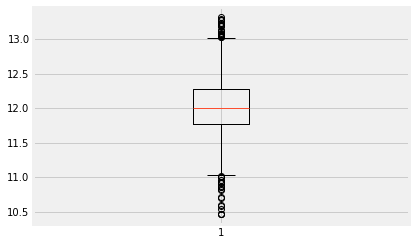

In [21]:
plt.boxplot(np.log(training_homes_price));

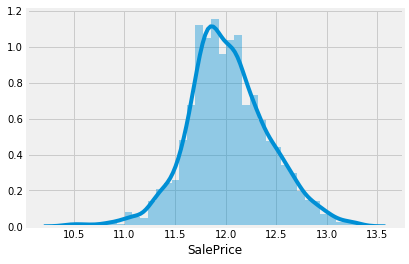

In [22]:
sns.distplot(np.log(training_homes_price));

In [23]:
#That looks better.  Lets save the log value in to our data.
training_homes_price = np.log(training_homes_price)

In [24]:
#Lets look at the values instead.
pd.DataFrame(training_homes.corr()['SalePrice'].sort_values(ascending=False)[1:50])

,SalePrice
Overall Qual,0.799391
Gr Liv Area,0.696303
Garage Area,0.653200
Garage Cars,0.649853
Total Bsmt SF,0.628332
1st Flr SF,0.618136
Year Built,0.571178
Year Remod/Add,0.549671
Full Bath,0.537263
Foundation_PConc,0.528543


In [25]:
#And grab a list of the top 50 correlations with SalePrice.
training_homes.corr()['SalePrice'].sort_values(ascending=False)[1:50].index

Index(['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',
       'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add',
       'Full Bath', 'Foundation_PConc', 'Mas Vnr Area', 'TotRms AbvGrd',
       'Fireplaces', 'BsmtFin Type 1_GLQ', 'Neighborhood_NridgHt',
       'Exter Qual_Gd', 'BsmtFin SF 1', 'Fireplace Qu_Gd', 'Bsmt Exposure_Gd',
       'Garage Type_Attchd', 'Sale Type_New', 'Exterior 1st_VinylSd',
       'Exterior 2nd_VinylSd', 'Open Porch SF', 'Wood Deck SF',
       'Mas Vnr Type_Stone', 'Kitchen Qual_Gd', 'Lot Area', 'Paved Drive_Y',
       'Bsmt Full Bath', 'Half Bath', 'Central Air_Y', 'Garage Cond_TA',
       'Roof Style_Hip', 'Neighborhood_NoRidge', 'Garage Yr Blt',
       'Neighborhood_StoneBr', 'Mas Vnr Type_BrkFace', 'Electrical_SBrkr',
       '2nd Flr SF', 'Garage Qual_TA', 'MS Zoning_RL', 'Bsmt Qual_Gd',
       'Garage Type_BuiltIn', 'Land Contour_HLS', 'House Style_2Story',
       'Bsmt Unf SF', 'Garage Finish_RFn', 'Lot Frontage'],
      dtype='ob

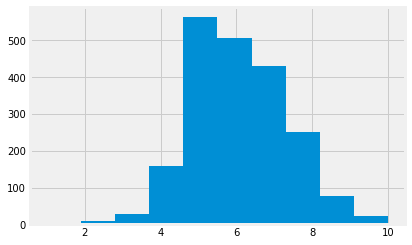

In [26]:
#Lets examine some of these. Starting with Overall Quality.
#Its on a scale from 1-10, so lets make 10 bins.
plt.hist(training_homes['Overall Qual'], bins=10);

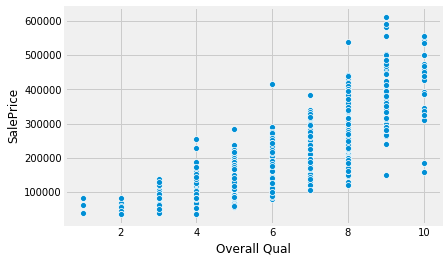

In [27]:
#And see how it relates to sale price...
sns.scatterplot(training_homes['Overall Qual'], training_homes['SalePrice']);

We see what we would expect. Sale Price Increases as Overall Quality Increases.

Of note... there are some outliers with quality 9 ad 10... with a low price... Suspicious...

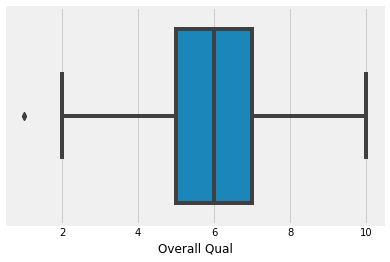

In [28]:
#On a boxplot...
sns.boxplot(training_homes['Overall Qual'])

In [29]:
training_homes['Overall Qual'].value_counts()

5     563
6     506
7     431
8     250
4     159
9      77
3      29
10     23
2       8
1       3
Name: Overall Qual, dtype: int64

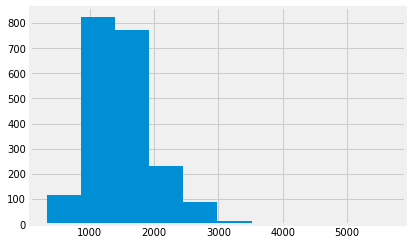

In [30]:
# Overall Quality looks legit... Lets look at Living Area... afterall thats what most people look at in listings!
plt.hist(training_homes['Gr Liv Area']);

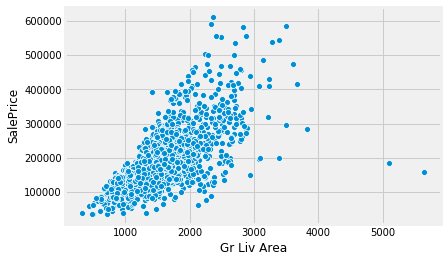

In [31]:
#And see how it relates to sale price...
sns.scatterplot(training_homes['Gr Liv Area'], training_homes['SalePrice']);

(2049, 259)

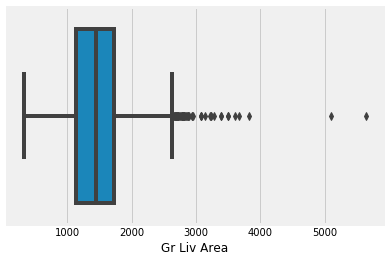

In [32]:
#On a boxplot...
sns.boxplot(training_homes['Gr Liv Area'])
training_homes.shape

In [33]:
#Something is a bit off with those two.  We have a lot of outliers in general.
normal_house_size = training_homes['Gr Liv Area'] < 3000
training_homes = training_homes[normal_house_size]
training_homes.shape

(2032, 259)

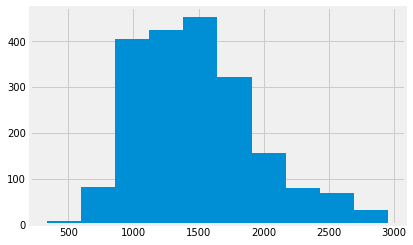

In [34]:
plt.hist(training_homes['Gr Liv Area']);

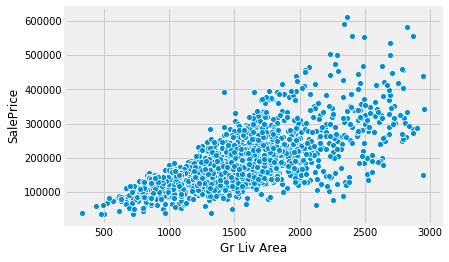

In [35]:
sns.scatterplot(training_homes['Gr Liv Area'], training_homes['SalePrice']);

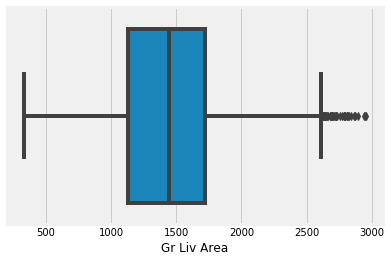

In [36]:
sns.boxplot(training_homes['Gr Liv Area'])

In [37]:
print("Total homes over 3000sq ft: ",sum(df['Gr Liv Area'] > 3000))
print("Training Set homes over 3000sq ft: ",sum(train['Gr Liv Area'] > 3000))
print("Testing Set homes over 3000sq ft: ",sum(test_houses['Gr Liv Area'] > 3000))

Total homes over 3000sq ft:  25
Training Set homes over 3000sq ft:  17
Testing Set homes over 3000sq ft:  8


GARAGE AREA

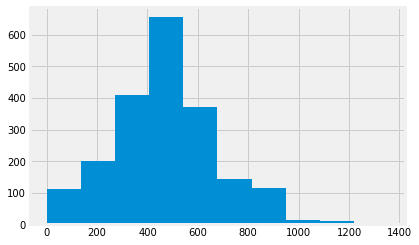

In [38]:
# Garage Area
plt.hist(training_homes['Garage Area']);

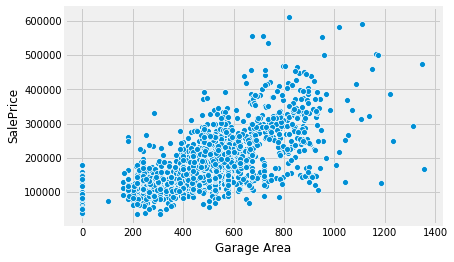

In [39]:
#And see how it relates to sale price...
sns.scatterplot(training_homes['Garage Area'], training_homes['SalePrice']);

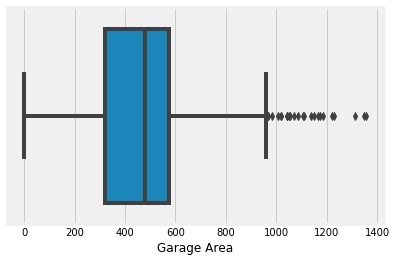

In [40]:
sns.boxplot(training_homes['Garage Area'])

In [41]:
sum(training_homes['Garage Area'] > 1200)

5

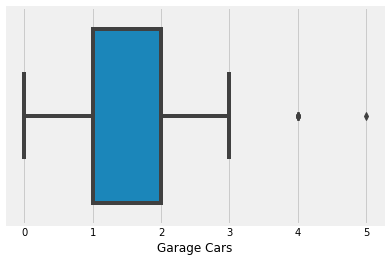

In [42]:
sns.boxplot(training_homes['Garage Cars'])

In [43]:
normal_garage_size = training_homes['Garage Area'] < 1200
training_homes = training_homes[normal_garage_size]
training_homes.shape

(2027, 259)

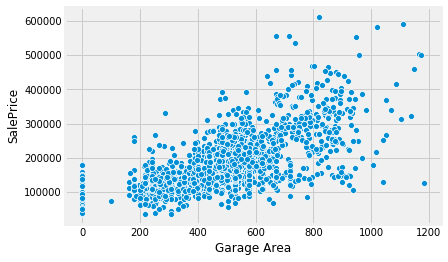

In [44]:
#And see how it relates to sale price...
sns.scatterplot(training_homes['Garage Area'], training_homes['SalePrice']);

In [45]:
print("Total homes under 1200sq ft of Garage Area: ",sum(df['Garage Area'] > 1200))
print("Training Set homes under 1200sq ft of Garage Area: ",sum(train['Garage Area'] > 1200))
print("Testing Set homes under 1200sq ft of Garage Area: ",sum(test_houses['Garage Area'] > 1200))

Total homes under 1200sq ft of Garage Area:  9
Training Set homes under 1200sq ft of Garage Area:  6
Testing Set homes under 1200sq ft of Garage Area:  3


TOTAL BSMT SQ FT

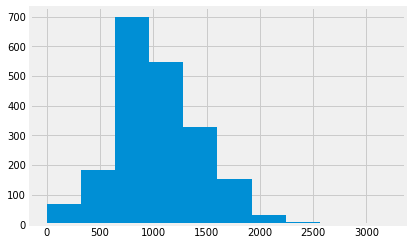

In [46]:
# TOTAL BSMT SQ FT
plt.hist(training_homes['Total Bsmt SF']);

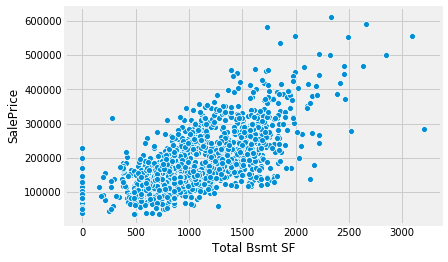

In [47]:
#And see how it relates to sale price...
sns.scatterplot(training_homes['Total Bsmt SF'], training_homes['SalePrice']);

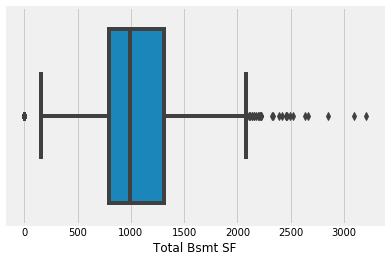

In [48]:
sns.boxplot(training_homes['Total Bsmt SF'])

In [49]:
sum(training_homes['Total Bsmt SF'] > 2500)

6

In [50]:
normal_basement_size = training_homes['Total Bsmt SF'] < 2500
training_homes = training_homes[normal_basement_size]
training_homes.shape

(2021, 259)

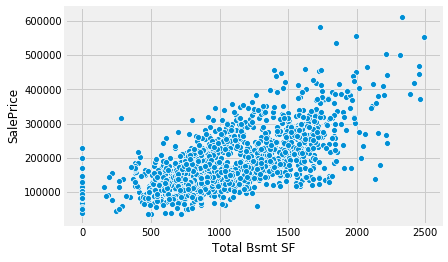

In [51]:
#And see how it relates to sale price...
sns.scatterplot(training_homes['Total Bsmt SF'], training_homes['SalePrice']);

In [52]:
print("Total homes with less than 2500sq ft of basement: ",sum(df['Total Bsmt SF'] > 2500))
print("Training Set homes with less than 2500sq ft of basement: ",sum(train['Total Bsmt SF'] > 2500))
print("Testing Set homes with less than 2500sq ft of basement: ",sum(test_houses['Total Bsmt SF'] > 2500))

Total homes with less than 2500sq ft of basement:  12
Training Set homes with less than 2500sq ft of basement:  9
Testing Set homes with less than 2500sq ft of basement:  3


1st Flr SF

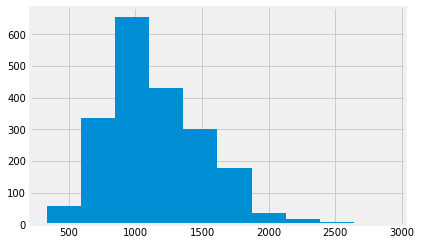

In [53]:
plt.hist(training_homes['1st Flr SF']);

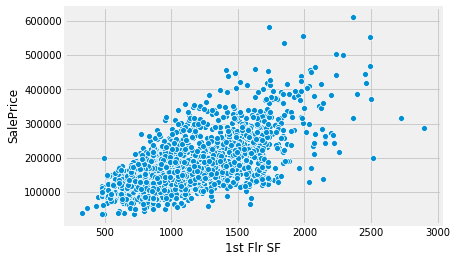

In [54]:
#And see how it relates to sale price...
sns.scatterplot(training_homes['1st Flr SF'], training_homes['SalePrice']);

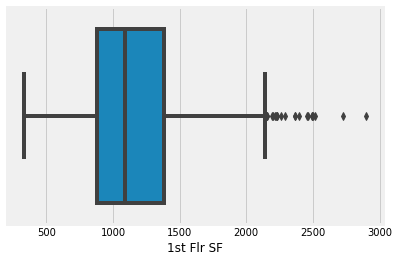

In [55]:
sns.boxplot(training_homes['1st Flr SF'])

In [56]:
sum(training_homes['1st Flr SF'] > 2600)

2

In [57]:
normal_1stflr_size = training_homes['1st Flr SF'] < 2600
training_homes = training_homes[normal_1stflr_size]
training_homes.shape

(2019, 259)

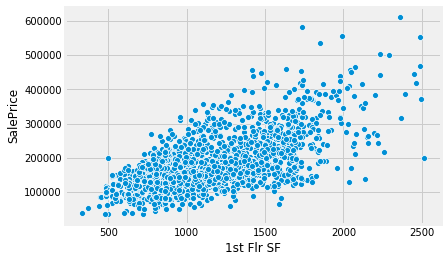

In [58]:
sns.scatterplot(training_homes['1st Flr SF'], training_homes['SalePrice']);

In [59]:
print("Total homes with less than 2600sq ft of First Floor: ",sum(df['1st Flr SF'] > 2600))
print("Training Set homes with less than 2600sq ft of First Floor: ",sum(train['1st Flr SF'] > 2600))
print("Testing Set homes with less than 2600sq ft of First Floor: ",sum(test_houses['1st Flr SF'] > 2600))

Total homes with less than 2600sq ft of First Floor:  9
Training Set homes with less than 2600sq ft of First Floor:  8
Testing Set homes with less than 2600sq ft of First Floor:  1


YEAR BUILT

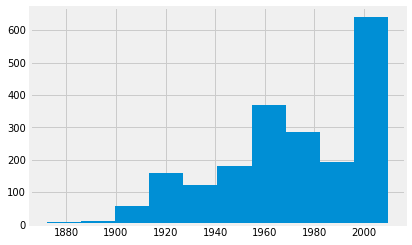

In [60]:
plt.hist(training_homes['Year Built']);

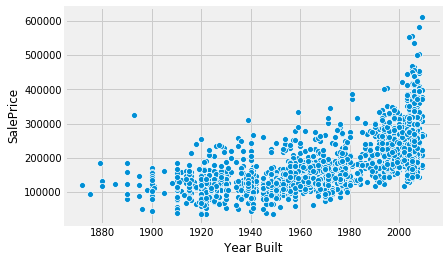

In [61]:
#And see how it relates to sale price...
sns.scatterplot(training_homes['Year Built'], training_homes['SalePrice']);

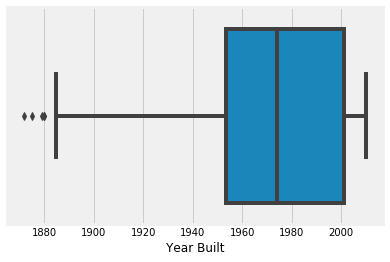

In [62]:
sns.boxplot(training_homes['Year Built'])

In [63]:
sum(training_homes['Year Built'] <= 1885)

6

In [64]:
normal_yearbuilt = training_homes['Year Built'] > 1885
training_homes = training_homes[normal_yearbuilt]
training_homes.shape

(2013, 259)

In [65]:
print("Total homes built before 1890: ",sum(df['Year Built'] < 1885))
print("Training Set homes built before 1890: ",sum(train['Year Built'] < 1885))
print("Testing Set homes built before 1890: ",sum(test_houses['Year Built'] < 1885))

Total homes built before 1890:  9
Training Set homes built before 1890:  6
Testing Set homes built before 1890:  3


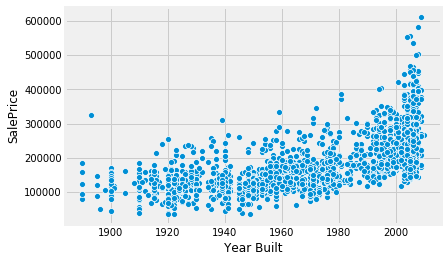

In [66]:
#And see how it relates to sale price...
sns.scatterplot(training_homes['Year Built'], training_homes['SalePrice']);

In [67]:
training_homes['SalePrice'].head()

0    130500.0
1    220000.0
2    109000.0
3    174000.0
4    138500.0
Name: SalePrice, dtype: float64

TIME TO ASSIGN OUR VARIABLES AND START MODELING!

In [68]:
#Assign X and Y (remember we wanted the LOG of Sale Price)
X = training_homes.drop(columns= 'SalePrice')
y = np.log(training_homes['SalePrice'])

In [69]:
y.head()

0    11.779129
1    12.301383
2    11.599103
3    12.066811
4    11.838626
Name: SalePrice, dtype: float64

In [70]:
#Set up Train/Test/Split
X_train, X_test, y_train, y_test = train_test_split(X.dropna(), y[X.dropna().index], random_state=42)

In [71]:
# Scale our data.
# Instantiate our Scaler
sc = StandardScaler()

#Fit and transform our triaing data.
X_train = sc.fit_transform(X_train)

#Fit and transform our testing data.
X_test = sc.transform(X_test)

In [72]:
#Model Prep - Use LR, Lasso, and Ridge models.
lr = LinearRegression()
lasso = LassoCV(n_alphas=1000)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

In [73]:
pd.DataFrame(X_train, columns=X.columns).isnull().sum() # .isnull().sum()

1st Flr SF              0
2nd Flr SF              0
3Ssn Porch              0
Bedroom AbvGr           0
Bsmt Full Bath          0
Bsmt Half Bath          0
Bsmt Unf SF             0
BsmtFin SF 1            0
BsmtFin SF 2            0
Enclosed Porch          0
Fireplaces              0
Full Bath               0
Garage Area             0
Garage Cars             0
Garage Yr Blt           0
Gr Liv Area             0
Half Bath               0
Id                      0
Kitchen AbvGr           0
Lot Area                0
Lot Frontage            0
Low Qual Fin SF         0
MS SubClass             0
Mas Vnr Area            0
Misc Val                0
Mo Sold                 0
Open Porch SF           0
Overall Cond            0
Overall Qual            0
PID                     0
Pool Area               0
Screen Porch            0
TotRms AbvGrd           0
Total Bsmt SF           0
Wood Deck SF            0
Year Built              0
Year Remod/Add          0
Yr Sold                 0
Alley_Pave  

In [74]:
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=5)
lasso_scores.mean()

/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, Fut

0.9157523707978426

In [75]:
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=5)
ridge_scores.mean()

0.9048942951858286

In [76]:
#Lets move forward with Lasso... its doing the best by a tiny margin.
lasso.fit(X_train, y_train)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=1000, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [77]:
#Score it on the training split
lasso.score(X_train, y_train)

0.9369882549063618

In [78]:
#Score it on our testing split of the "Training" set.
lasso.score(X_test, y_test)

0.9300293402913391

In [79]:
train_predictions = lasso.predict(X_test)
pd.DataFrame(train_predictions).head()

,0
0,11.860881
1,11.682899
2,11.582015
3,12.136402
4,12.068968


# Better performance on our testing split, which is good.  Low bias, numbers are close together, so low variance...
# Looking good so far!


In [80]:
testing_homes.shape

(878, 259)

In [81]:
testing_homes = testing_homes.drop(columns= 'SalePrice')

In [82]:
#Scale our TEST data same way we did above with our scaler
test_houses_sc = sc.transform(testing_homes)
test_houses_sc.shape

(878, 258)

In [83]:
#Make our predictions using lasso, as it had the best results from above.
predictions = lasso.predict(test_houses_sc)

In [84]:
#Lets look at what we got...
pd.DataFrame(predictions).head()
#Hmmmm looks like we need to exponentiate it back to get non-logged versions.

,0
0,11.639802
1,11.955210
2,12.280580
3,11.562932
4,12.052340


In [85]:
preds = np.exp(predictions)

In [86]:
test_houses['SalePrice'] = preds

submission = test_houses[['Id', 'SalePrice']]

In [87]:
# submission.to_csv('./submissions/10_3_Lasso_trimmed.csv', index = False)

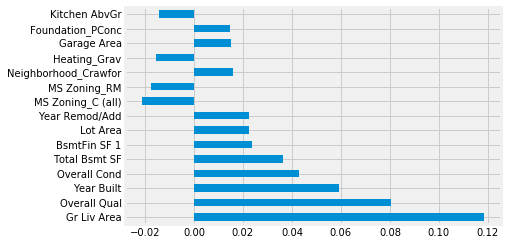

In [88]:
## 

coef_df = pd.concat([pd.DataFrame(lasso.coef_, index=X.columns, columns=['Coef']), \
           pd.DataFrame(abs(lasso.coef_), index=X.columns, columns=['ABS'])], axis=1)

coef_df.sort_values('ABS', ascending=False)['Coef'].head(15).plot.barh();

In [89]:
# poly = PolynomialFeatures(2, interaction_only=True)
# X_train_poly = poly.fit_transform(X_train)

In [90]:
# lasso_scores = cross_val_score(lasso, X_train_poly, y_train, cv=5)
# lasso_scores.mean()

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
submission.columns = ['Id', 'SalePrice']

pd.set_option('max_columns', 99)
import warnings
from IPython.display import HTML
warnings.filterwarnings('ignore')

full_data = pd.read_csv('../data/amesfull.csv', index_col='Unnamed: 0')

## Almost all of my students named their df "submission" but you just need to merge on that df

results = full_data[['Order', 'SalePrice']].merge(submission, left_on='Order', \
                                          right_on='Id', suffixes=('_Actual', '_Predicted'))

results['Residuals'] = results['SalePrice_Actual'] - results['SalePrice_Predicted']
results['Squared_Residuals'] = results['Residuals'] ** 2

results.loc[results['Residuals'].abs()> 110000,:].sort_values\
('Squared_Residuals', ascending=False) # largest residual homes 

,Order,SalePrice_Actual,Id,SalePrice_Predicted,Residuals,Squared_Residuals
296,957,375000,957,624532.365337,-249532.365337,6.226640e+10
37,126,84900,126,213467.930086,-128567.930086,1.652971e+10
487,1571,228950,1571,347014.925798,-118064.925798,1.393933e+10


In [92]:
import chart_studio.plotly as py
import plotly.graph_objs as go

import squarify

ten_largest = results.sort_values('Squared_Residuals', ascending=False).set_index('Order')['Squared_Residuals'].head(10)
other_869 = results.sort_values('Squared_Residuals', ascending=False).iloc[10:]['Squared_Residuals'].sum()
total_error = results['Squared_Residuals'].sum()

ten_largest = results.sort_values('Squared_Residuals', ascending=False).set_index('Order')['Squared_Residuals'].head(10)
other_869 = results.sort_values('Squared_Residuals', ascending=False).iloc[10:]['Squared_Residuals'].sum()

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(results['SalePrice_Predicted'], results['SalePrice_Actual'])
ax.set_xlabel('Predictions', fontsize=18)
ax.set_ylabel('Actual Prices', fontsize=18);

ModuleNotFoundError: No module named 'chart_studio'

In [ ]:
trace = go.Scatter(x= results['SalePrice_Predicted'], y=results['Residuals'],\
                  mode= 'markers', hovertext='ID: ' + results['Order'].astype(str), \
                  hoverinfo='text')

layout = go.Layout(xaxis= {'title':{'text':'Predictions', 'font':{'size':18}}}, 
                  yaxis={'title':{'text':'Residuals', 'font':{'size':18}}})

fig = {'data':[trace], 'layout':layout}

py.iplot(fig , filename='scatter-bm', fileopt='overwrite')

In [ ]:
results['Squared_Residuals'].mean() ** .5

In [ ]:
ten_largest.index = ["ID: " + str(i) for i in ten_largest.index]

# final_series = ten_largest.append(pd.Series(other_869, index=['Other 869']) )

# final_series = final_series.sort_values()

# x = 0.
# y = 0.
# width = 100.
# height = 100.

# values = list(final_series.values)

# normed = squarify.normalize_sizes(values, width, height)
# rects = squarify.squarify(normed, x, y, width, height)
# pcts = [str(i)+'%' for i in((.5 - ((final_series / (final_series[-1]*2))))+.45)*100]

# color_brewer = [f'hsl(205.0, 55.0%, {pct})' for pct in pcts]
# shapes = []
# annotations = []
# counter = 0

# for r in rects:
#     shapes.append( 
#         dict(
#             type = 'rect', 
#             x0 = r['x'], 
#             y0 = r['y'], 
#             x1 = r['x']+r['dx'], 
#             y1 = r['y']+r['dy'],
#             line = dict( width = 2 ),
#             fillcolor = color_brewer[counter]
#         ) 
#     )
#     annotations.append(
#         dict(
#             x = r['x']+(r['dx']/2),
#             y = r['y']+(r['dy']/2),
#             text = final_series.index[counter],
#             showarrow = False
#         )
#     )
#     counter = counter + 1
#     if counter >= len(rects):
#         counter = 0

# # For hover text
# trace0 = go.Scatter(
#     x = [ r['x']+(r['dx']/2) for r in rects ], 
#     y = [ r['y']+(r['dy']/2) for r in rects ],
#     text = [ str(round((v / total_error *100), 2))+'% of total error' for v in values ], 
#     mode = 'text',
# )
        
# layout = dict(
#     title = f'RMSE = {round(results["Squared_Residuals"].mean()**.5)}',
#     height=900, 
#     width=900,
#     xaxis=dict(showgrid=False,zeroline=False),
#     yaxis=dict(showgrid=False,zeroline=False),
#     shapes=shapes,
#     annotations=annotations,
#     hovermode='closest'
# )

# # With hovertext
# figure = dict(data=[trace0], layout=layout)

# # Without hovertext
# # figure = dict(data=[Scatter()], layout=layout)

# py.iplot(figure, filename='squarify-treemap-bc')